In [1]:
#  G.V.S.Sri Ram, 15CE31015
#  Department of Civil Engineering, IIT, Kharagpur

In [2]:
import math
import numpy as np
import random

In [3]:
class Node(object):
    def __init__(self,**kwargs):
        for key,value in kwargs.items():
            vars(self)[key]=value

In [4]:
class Element(object):
    def __init__(self,**kwargs):
        for key,value in kwargs.items():
            vars(self)[key]=value

In [5]:
class ElementTrussXY(Element):
    def __init__(self,**kwargs):
        Element.__init__(self,**kwargs)
                
        self.mdof=4        
        self.ke=np.zeros((4,4),float)
        self.ok=np.zeros((4,4),float)
        self.ot=np.zeros((4,4),float)
        self.jdofv=np.zeros((4),int)

                         
    def computeStiffnessMatrix(self,NODE):
        
        self.c=np.zeros((self.mdof,self.mdof),float)
        
        for i in range(self.mdof):
            for j in range(self.mdof):
                self.c[i,j]=0.0

        n1=self.nodes[0]
        n2=self.nodes[1]
        self.jdofv[0]=2*n1-1
        self.jdofv[1]=2*n1
        self.jdofv[2]=2*n2-1
        self.jdofv[3]=2*n2
                         
        xx=NODE[n2].x-NODE[n1].x
        yy=NODE[n2].y-NODE[n1].y

        A=self.A
 
        E=self.E

        L=math.sqrt((xx*xx+yy*yy))
        for i in range(4):
            for j in range(4):
                self.ok[i,j]=0.0
                self.ot[i,j]=0.0
            self.ot[i,i]=1.0    

        C = xx / L
        S = yy / L
        self.ot[0,0]=C
        self.ot[0,1]=S
        self.ot[1,0]=-S
        self.ot[1,1]=C
        self.ot[2,2]=C
        self.ot[2,3]=S
        self.ot[3,2]=-S
        self.ot[3,3]=C

        AE_by_L = A * E / L

        self.ke[0,0]=      AE_by_L
        self.ke[0,2]=     -AE_by_L
    
        self.ke[2,0]=     -AE_by_L
        self.ke[2,2]=      AE_by_L

        for i in range(4):
            for j in range(4):
                self.c[i,j]=0.0
                for k in range(4):
                    self.c[i,j]=self.c[i,j]+self.ot[k,i]*self.ke[k,j]

        for i in range(4):
            for j in range(4):
                self.ok[i,j]=0.0
                for k in range(4):
                    self.ok[i,j]=self.ok[i,j]+self.c[i,k]*self.ot[k,j]

        del self.c

    def assembleStiffness(self,gk):
        
        for i in range(self.mdof):
            ii=self.jdofv[i]
            if ii > 0:
                for j in range(self.mdof):
                    jj=self.jdofv[j]
                    if jj > 0:
                       gk[ii-1,jj-1]=gk[ii-1,jj-1]+self.ok[i,j]
    
    def computeLength(self,NODE):
        n1=self.nodes[0]
        n2=self.nodes[1]
        N1=NODE[n1]
        N2=NODE[n2]
        self.l = math.sqrt((N1.x - N2.x)**2+(N1.y - N2.y)**2)
    
    
    def computeMemberForces(self,NODE):
            self.computeStiffnessMatrix(NODE)
            mfg=[0,0,0,0]
            mfl=[0,0,0,0]
            disp=[0,0,0,0]
            n1=self.nodes[0]
            n2=self.nodes[1]
            N1=NODE[n1]
            N2=NODE[n2]
            disp[0]=N1.Dx
            disp[1]=N1.Dy
            disp[2]=N2.Dx
            disp[3]=N2.Dy
           
            for i in range(4):
                mfg[i]=0.0
                for j in range(4):
                    mfg[i]=mfg[i]+self.ok[i,j]*disp[j]
                    
            for i in range(4):
                mfl[i]=0.0
                for j in range(4):
                    mfl[i]=mfl[i]+self.ot[i,j]*mfg[j]

            self.mfl=mfl
    

In [6]:
class Structure(object):
   
    def __init__(self,**kwargs):
        self.title='Untitled'
        self.numnode=0
        self.numelem=0
        self.NODE=dict()
        self.ELEM=dict()
        self.NODE_LIST=list()
        self.ELEM_LIST=list()

    def node(self, **kwargs):
        if 'NODE' not in vars(self):
            self.NODE=dict()
        if 'NODE_LIST' not in vars(self):
            self.NODE_LIST=list()
        
        if 'nid' in kwargs:
            nid=kwargs['nid']
            self.NODE[nid]=Node(**kwargs)
            self.NODE_LIST.append(nid)
            self.numnode=self.numnode+1
                

    def element(self, **kwargs):
        if 'ELEM' not in vars(self):
            self.ELEM=dict()
        if 'ELEM_LIST' not in vars(self):
            self.ELEM_LIST=list()

        if 'eid' in kwargs:
            eid=kwargs['eid']
            if 'etype' in kwargs:
                self.etype=kwargs['etype']
            if self.etype == 'TrussXY':
               self.ELEM[eid]=ElementTrussXY(**kwargs)
            
            
            self.ELEM_LIST.append(eid)
            self.numelem=self.numelem+1
            
    def solve(self,**kwargs):
        self.ndof=2*self.numnode
        self.gk=np.zeros((self.ndof,self.ndof),float)
        self.gp=np.zeros((self.ndof,1),float)

        for eid in self.ELEM_LIST:
            self.ELEM[eid].computeStiffnessMatrix(self.NODE)
            self.ELEM[eid].assembleStiffness(self.gk)

        for nid in self.NODE_LIST:
            N=self.NODE[nid]
            i1=2*nid-1
            i2=2*nid
            
            if 'Fx' in vars(N):
                self.gp[i1-1,0]=N.Fx

            if 'Fy' in vars(N):
                self.gp[i2-1,0]=N.Fy

            if 'idx' in vars(N):
                idx=N.idx
                if idx == 1:
                    for i in range(self.ndof):
                        self.gk[i,i1-1]=0.0
                        self.gk[i1-1,i]=0.0
                    self.gk[i1-1,i1-1]=1.0

            if 'idy' in vars(N):
                idy=N.idy
                if idy == 1:
                    for i in range(self.ndof):
                        self.gk[i,i2-1]=0.0
                        self.gk[i2-1,i]=0.0
                    self.gk[i2-1,i2-1]=1.0

        self.disp=np.linalg.solve(self.gk,self.gp)

        for nid in self.NODE_LIST:
            i1=2*nid-1
            i2=2*nid
            self.NODE[nid].Dx=self.disp[i1-1,0]
            self.NODE[nid].Dy=self.disp[i2-1,0]

        for eid in self.ELEM_LIST:
            self.ELEM[eid].computeMemberForces(self.NODE)
            self.ELEM[eid].computeLength(self.NODE)
            
    def showStructure(self,**kwargs):
        for key,value in kwargs.items():
            vars(self)[key]=value
        plt.axis((-5.0,55.0,-5.0,55.0))
        ax=plt.gca()
        plt.axis('off')
        for eid in self.ELEM_LIST:
            n1=self.ELEM[eid].nodes[0]
            n2=self.ELEM[eid].nodes[1]
            N1=self.NODE[n1]
            N2=self.NODE[n2]
            p1=[N1.x,N1.y]
            p2=[N2.x,N2.y]
#            print(eid,n1,n2,p1,p2)
            l=mlines.Line2D([N1.x,N2.x],[N1.y,N2.y])
            ax.add_line(l)
            
        plt.show()
            

In [7]:
def sri_truss_bridge_xy():
        a=5.0
        h=7.0
        L=6*a
        A_bot=0.1
        A_top=0.1
        A_diag=0.1
        A_vert=0.1
        Iz_bot=0.5e-05
        Iz_top=0.5e-05
        Iz_diag=0.5e-05
        Iz_vert=0.5e-05
        E=2.0e10
        rho=7850
        m_bar=rho*A_bot
        pstr=Structure(etype='TrussXY',title="Truss Bridge - span 30 m")
        
        pstr.node(nid=0,tagid='L0',x=0.0,  y=0, idx=1, idy=1 )
        pstr.node(nid=1,tagid='L1',x=a, y=0, Fy=-250000.0 )
        pstr.node(nid=2,tagid='L2',x=2*a, y=0, Fy=-250000.0 )
        pstr.node(nid=3,tagid='L3',x=3*a, y=0, Fy=-250000.0 )
        pstr.node(nid=4,tagid='L4',x=4*a, y=0, Fy=-250000.0 )
        pstr.node(nid=5,tagid='L5',x=5*a, y=0, Fy=-250000.0 )
        pstr.node(nid=6,tagid='L6',x=6*a, y=0, idy=1 )
        
        pstr.node(nid=7,tagid='U1',x=a, y=h )
        pstr.node(nid=8,tagid='U2',x=2*a, y=h )
        pstr.node(nid=9,tagid='U3',x=3*a, y=h )
        pstr.node(nid=10,tagid='U4',x=4*a, y=h )
        pstr.node(nid=11,tagid='U5',x=5*a, y=h )

        pstr.element(eid=1,  tagid='L0-L1',etype='TrussXY',nodes=(0,1),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
        pstr.element(eid=2,  tagid='L1-L2',nodes=(1,2),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
        pstr.element(eid=3,  tagid='L2-L3',nodes=(2,3),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
        pstr.element(eid=4,  tagid='L3-L4',nodes=(3,4),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
        pstr.element(eid=5,  tagid='L4-L5',nodes=(4,5),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
        pstr.element(eid=6,  tagid='L5-L6',nodes=(5,6),
                     A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)

        
        pstr.element(eid=7,  tagid='U1-U2',nodes=(7,8),
                     A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
        pstr.element(eid=8, tagid='U2-U3',nodes=(8,9),
                     A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
        pstr.element(eid=9, tagid='U3-U4',nodes=(9,10),
                     A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
        pstr.element(eid=10, tagid='U4-U5',nodes=(10,11),
                     A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)

        
        pstr.element(eid=11, tagid='L0-U1',nodes=(0,7),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
        pstr.element(eid=12, tagid='L2-U1',nodes=(2,7),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
        pstr.element(eid=13, tagid='L2-U3',nodes=(2,9),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
        pstr.element(eid=14, tagid='L4-U3',nodes=(4,9),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
        pstr.element(eid=15, tagid='L4-U5',nodes=(4,11),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
        pstr.element(eid=16, tagid='L6-U5',nodes=(6,11),
                     A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
 
        
        pstr.element(eid=17, tagid='L1-U1',nodes=(1,7),
                     A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
        pstr.element(eid=18, tagid='L2-U2',nodes=(2,8),
                     A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
        pstr.element(eid=19, tagid='L3-U3',nodes=(3,9),
                     A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
        pstr.element(eid=20, tagid='L4-U4',nodes=(4,10),
                     A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
        pstr.element(eid=21, tagid='L5-U5',nodes=(5,11),
                     A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)

        
        return pstr

#        pstr.solve()
        
#        print('Nodes')
#        for nid in pstr.NODE_LIST:
#            N=pstr.NODE[nid]
#            print(nid,N.x,N.y,N.Dx,N.Dy)
            
#        print('Elements')

#        for eid in pstr.ELEM_LIST:
#            E=pstr.ELEM[eid]
#            print(eid,E.nodes,E.A,E.E,E.mfl[0])


In [8]:
# Prepare model

pstr=sri_truss_bridge_xy()

pstr.solve()

print ('Nodes')

for nid in pstr.NODE_LIST:
    N=pstr.NODE[nid]
    print (vars(N))

print('Nodes')
for nid in pstr.NODE_LIST:
    N=pstr.NODE[nid]
    print(N.nid,N.x,N.y)
    
print('Elements')

for eid in pstr.ELEM_LIST:
    E=pstr.ELEM[eid]
    print(E.eid,E.nodes,E.A,E.E,E.mfl[0])
    



Nodes
{'nid': 0, 'tagid': 'L0', 'x': 0.0, 'y': 0, 'idx': 1, 'idy': 1, 'Dx': 0.0, 'Dy': 0.0}
{'nid': 1, 'tagid': 'L1', 'x': 5.0, 'y': 0, 'Fy': -250000.0, 'Dx': 0.001116071428571432, 'Dy': -0.010515127995925744}
{'nid': 2, 'tagid': 'L2', 'x': 10.0, 'y': 0, 'Fy': -250000.0, 'Dx': 0.002232142857142864, 'Dy': -0.01606195989552201}
{'nid': 3, 'tagid': 'L3', 'x': 15.0, 'y': 0, 'Fy': -250000.0, 'Dx': 0.004241071428571441, 'Dy': -0.019183863045727573}
{'nid': 4, 'tagid': 'L4', 'x': 20.0, 'y': 0, 'Fy': -250000.0, 'Dx': 0.0062500000000000186, 'Dy': -0.01606195989552201}
{'nid': 5, 'tagid': 'L5', 'x': 25.0, 'y': 0, 'Fy': -250000.0, 'Dx': 0.007366071428571448, 'Dy': -0.010515127995925745}
{'nid': 6, 'tagid': 'L6', 'x': 30.0, 'y': 0, 'idy': 1, 'Dx': 0.008482142857142879, 'Dy': 0.0}
{'nid': 7, 'tagid': 'U1', 'x': 5.0, 'y': 7.0, 'Dx': 0.007812500000000016, 'Dy': -0.009640127995925745}
{'nid': 8, 'tagid': 'U2', 'x': 10.0, 'y': 7.0, 'Dx': 0.0060267857142857284, 'Dy': -0.016061959895522015}
{'nid': 9, 't

In [9]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

pstr.showStructure()

<Figure size 640x480 with 1 Axes>

In [10]:
max_stress=120*10**6
min_A=0.025

#step-1
hms=20
hmcr=0.8
par=0.3
n_max=30000

In [11]:
def create_hm(min_A,j):
    x=random.uniform(min_A,1)
    E=pstr.ELEM[pstr.ELEM_LIST[j]]
    if abs(E.mfl[0]/x) < max_stress:
        return x
    else:
        create_hm(min_A,j)

In [12]:
#step-2
hm=[]
for i in range(hms):
    arr=[]
    for j in range(21):
        x=create_hm(min_A,j)
        arr.append(x)
            
    hm.append(arr)
    
print(hm)

[[0.31018977843204387, 0.3321720701827401, 0.8360914592455764, 0.7586427531145017, 0.32562170873421403, 0.22234562392902685, 0.4773400490448319, 0.5628211184430739, 0.1414019816321359, 0.2740568191018024, 0.8105145085208026, 0.37099496708239516, 0.8532275804038935, 0.9818199466915855, 0.8950633167559409, 0.41835355088855164, 0.921592433005727, 0.3955793860553843, 0.21418164103655965, 0.1227590191174254, 0.9769950194191955], [0.7377603215076749, 0.04663782533204687, 0.1309075590543964, 0.1274806711541393, 0.919474493703564, 0.6984097526625094, 0.5586038730569113, 0.3499091509780772, 0.37850454831324193, 0.997718988712316, 0.3122136327643665, 0.38366750163103064, 0.14427660649211582, 0.12491007987992794, 0.7381744489406337, 0.5493951312243093, 0.23337996093023822, 0.4118072907798248, 0.5121229239330634, 0.4748536803876983, 0.50386749827688], [0.2945539284774654, 0.056827332352226735, 0.4381152523707015, 0.8320005673054239, 0.17409896945896006, 0.12491749600542243, 0.17675877140429594, 0.

In [13]:
def get_weight(hm,hms):
    w=[]
    for i in range(hms):
        sum_row=0
        for j in range(21):
            E=pstr.ELEM[pstr.ELEM_LIST[j]]
            sum_row+=hm[i][j]*E.rho*E.l
        w.append(sum_row)
    return w

In [14]:
#step-3
def new_vector(hm,hms,hmcr,par):
    x_new=[]
    r1=random.random()
    if(r1<hmcr):
        arr=[]
        for j in range(21):
            for i in range(hms):
                arr.append(hm[i][j])
            x_new.append(random.choice(arr))
    else:
        for i in range(21):
            x_new.append(create_hm(min_A,i))
    r2=random.random()
    if(r2<par):
        for i in range(21):
            bw=0.01
            x_new[i]+=bw*random.uniform(-1,1)
    return x_new

In [15]:
w=get_weight(hm,hms)
print(w)
worst=w.index(max(w))
weights=[min(w)]
for i in range(n_max):
    x_new=new_vector(hm,hms,hmcr,par)
    #print(x_new)
    sum_row=0
    for j in range(len(x_new)):
        E=pstr.ELEM[pstr.ELEM_LIST[j]]
        sum_row+=x_new[j]*E.rho*E.l
    #print(sum_row,"\t",max(w))
    if sum_row<max(w):
        hm[worst]=x_new
        #print(hm)
        w=get_weight(hm,hms)
        worst=w.index(max(w))
    if i==1000 || i==2500 || i==5000 || i==10000 || i==20000:
        print("hm",hm)
        print("w",w)
    weights.append(min(w))

#print(w)
#print(weights)

[603421.7515022834, 463598.8240173254, 462606.33120597235, 569242.1601171566, 516390.32710745116, 590875.6813993596, 504712.39798377245, 497093.08066155756, 583174.7199385241, 476268.78484126786, 550440.112568583, 440219.59644948796, 551919.274871347, 448149.49888591183, 458450.010331262, 494944.02563350275, 533418.8103715916, 555208.0397070771, 517372.94953990506, 564279.7815271006]
hm [[0.2981997325525814, 0.2921432244161257, 0.2884657318255968, 0.2921432244161257, 0.2981997325525814, 0.27445484445591534, 0.2921432244161257, 0.036466075969313325, 0.2908469625980078, 0.2848792228162925, 0.2981997325525814, 0.03624831439109086, 0.039698829960052036, 0.28774328484380574, 0.27445484445591534, 0.036466075969313325, 0.048678230082297866, 0.2874394923265451, 0.03805946429920131, 0.29042390131059687, 0.03805946429920131], [0.2981997325525814, 0.2853846711962985, 0.2874394923265451, 0.2921432244161257, 0.2853846711962985, 0.2921432244161257, 0.2853846711962985, 0.28546225940818754, 0.29424036

hm [[0.2884005662197901, 0.28368263914031516, 0.2962981031225998, 0.28382655028716286, 0.038809037801129716, 0.2996595587771009, 0.28286594018327255, 0.029640452473836593, 0.03817850543698734, 0.2875776469936348, 0.03913620167425873, 0.0389385795263479, 0.28559851437628603, 0.28021287434681785, 0.2971342256725411, 0.047976869171251546, 0.29921094137952897, 0.058387391776740905, 0.27790457860027246, 0.0402604696497566, 0.0393228848598308], [0.2981997325525814, 0.29271484264466796, 0.2872314744783055, 0.29271484264466796, 0.2921432244161257, 0.2960847632145202, 0.29313641457127326, 0.2966971479146153, 0.2847514691017245, 0.2749494545857249, 0.2920978578707716, 0.053018712196323536, 0.036466075969313325, 0.03146214597719728, 0.057855889521450626, 0.04995202045504509, 0.2872314744783055, 0.02785588996369278, 0.2981997325525814, 0.036378139084876325, 0.04692440168213193], [0.29361914758081736, 0.29361914758081736, 0.2981997325525814, 0.2913131853928863, 0.2887420646512091, 0.285765760424516

hm [[0.2985103148157471, 0.2865841882145483, 0.2853943474974937, 0.2867054373892771, 0.27942207080015413, 0.2834892434732588, 0.2869813620160064, 0.295080640575437, 0.0406126378392052, 0.2899201449742948, 0.27355413094327025, 0.29136218418923737, 0.05200229276016414, 0.013361397360204228, 0.2803984087877767, 0.053289055494415705, 0.03882204141691232, 0.039596978076299486, 0.05967451121177968, 0.043404312708111056, 0.03171583401838204], [0.27504131453652064, 0.2786899292704475, 0.281786000446751, 0.292551860554423, 0.30929535314102563, 0.27759170049632026, 0.2794302191061417, 0.29005013511698113, 0.2893615211140923, 0.28513768800065536, 0.039387817507307285, 0.2908781026006498, 0.047112910770804775, 0.04827376309138808, 0.030595140414782056, 0.04575341269679751, 0.2793361387566192, 0.2878924642405119, 0.04819519462430407, 0.06090786181577241, 0.035757659715435895], [0.29361914758081736, 0.29361914758081736, 0.2981997325525814, 0.2913131853928863, 0.2887420646512091, 0.28576576042451685,

hm [[0.2985103148157471, 0.2865841882145483, 0.2853943474974937, 0.2867054373892771, 0.27942207080015413, 0.2834892434732588, 0.2869813620160064, 0.295080640575437, 0.0406126378392052, 0.2899201449742948, 0.27355413094327025, 0.29136218418923737, 0.05200229276016414, 0.013361397360204228, 0.2803984087877767, 0.053289055494415705, 0.03882204141691232, 0.039596978076299486, 0.05967451121177968, 0.043404312708111056, 0.03171583401838204], [0.2847580441827208, 0.2847514691017245, 0.28368263914031516, 0.2999210102132679, 0.298166166300222, 0.2981997325525814, 0.29361914758081736, 0.036466075969313325, 0.2908469625980078, 0.03845462789267063, 0.28309222883654617, 0.03159177461836445, 0.03159177461836445, 0.036466075969313325, 0.04398895786772323, 0.28236467587931746, 0.0463702510790931, 0.29259939283237846, 0.030015212782208037, 0.0463702510790931, 0.024286586922963566], [0.2847580441827208, 0.2865841882145483, 0.28260851742708704, 0.29271484264466796, 0.2902756915846222, 0.2966004778929441,

hm [[0.28316395542218886, 0.2958464939232137, 0.2729939661675603, 0.27791023870706477, 0.2914387143023505, 0.2864546194172867, 0.2920899136538492, 0.04605095270995742, 0.27066047283550665, 0.29546301950168746, 0.04263856126038892, 0.033536858357003804, 0.03600797317966473, 0.04572832233336896, 0.061774626317252376, 0.02428681349638243, 0.04604525365174281, 0.04849905784533663, 0.3070557488110684, 0.060244477191031764, 0.047117095457453684], [0.2847580441827208, 0.2847514691017245, 0.28368263914031516, 0.2999210102132679, 0.298166166300222, 0.2981997325525814, 0.29361914758081736, 0.036466075969313325, 0.2908469625980078, 0.03845462789267063, 0.28309222883654617, 0.03159177461836445, 0.03159177461836445, 0.036466075969313325, 0.04398895786772323, 0.28236467587931746, 0.0463702510790931, 0.29259939283237846, 0.030015212782208037, 0.0463702510790931, 0.024286586922963566], [0.2767374039152123, 0.276397580021601, 0.28232333006519583, 0.3008269850929406, 0.27881613765636437, 0.0361209798389

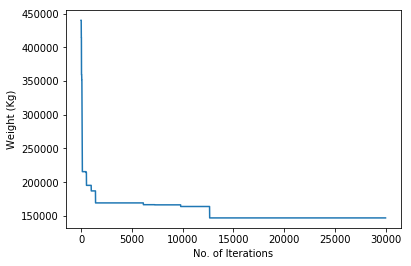

In [16]:
import matplotlib.pyplot as plt

g = plt.figure()
plt.plot(weights)
plt.xlabel("No. of Iterations")
plt.ylabel("Weight (Kg)")
plt.show()

g.savefig("harmony.pdf")